<a href="https://colab.research.google.com/github/SalarShafiee/Image-classification/blob/main/Alzaymer%20image%20classification-With%20TF.Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

100%|██████████| 71.5M/71.5M [00:02<00:00, 33.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model  # Corrected 'model' to 'Model'
# from tensorflow.keras.applications.inception_v3 import InceptionV3  # Example commented out
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob  # Corrected a typo: 'glob.' to 'glob'

In [4]:
train_path='/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/train'
test_path='/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test'

In [5]:
IMG_SIZE=[224,224]
BATCH_SIZE=16

In [6]:
import tensorflow as tf

In [19]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 10240 files belonging to 4 classes.


In [20]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1279 files belonging to 4 classes.


In [21]:
class_names = train_dataset.class_names
class_names

['Mild Impairment',
 'Moderate Impairment',
 'No Impairment',
 'Very Mild Impairment']

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [22]:
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_dataset:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print(class_counts)

{'Mild Impairment': 2560, 'Moderate Impairment': 2560, 'No Impairment': 2560, 'Very Mild Impairment': 2560}


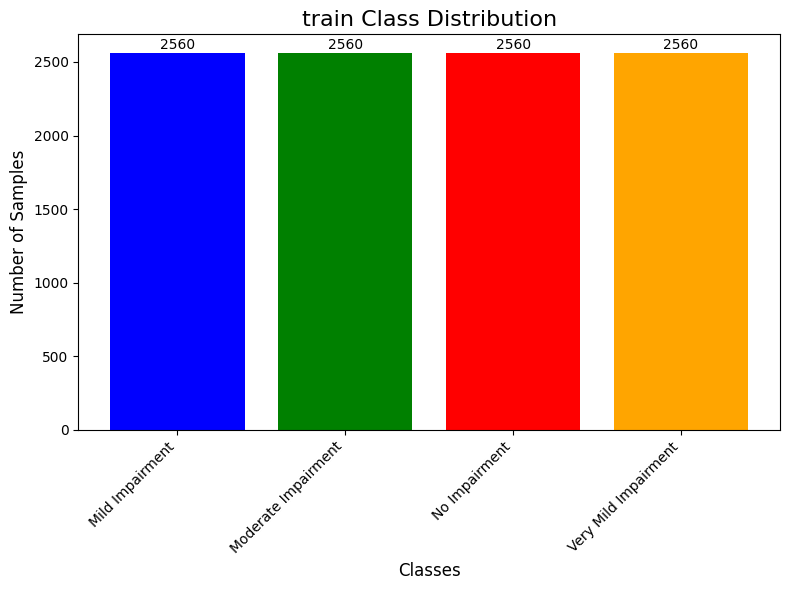

In [11]:
import matplotlib.pyplot as plt

# Assuming you have 'class_counts' dictionary from previous steps

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(class_names, list(class_counts.values()), color=['blue', 'green', 'red', 'orange'])  # Customize colors
plt.title('train Class Distribution', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels if needed
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout for better spacing

# Add data labels (optional)
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)  # Adjust position and font size

plt.show()

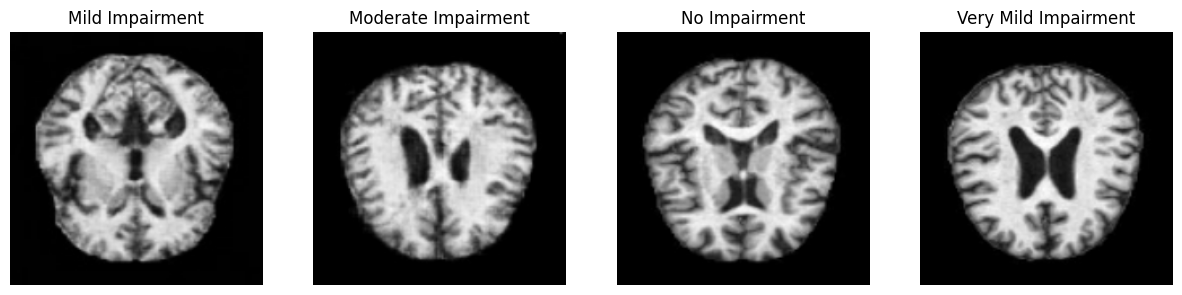

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assuming you have 'train_dataset' and 'class_names'

# Get one sample per class
sample_images = []
sample_labels = []

for images, labels in train_dataset.take(1):
    for i in range(len(class_names)):
        index = np.where(labels.numpy() == i)[0]
        if len(index) > 0:
            sample_images.append(images[index[0]].numpy())
            sample_labels.append(class_names[i])

# Display images using Pillow and Matplotlib
fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))  # Adjust figsize as needed

for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    img = Image.fromarray(image.astype("uint8"))  # Convert to PIL Image
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

In [13]:
val_batches = tf.data.experimental.cardinality(train_dataset)
val_batches


<tf.Tensor: shape=(), dtype=int64, numpy=640>

In [23]:
valid_dataset = train_dataset.take(val_batches // 5)
train_dataset = train_dataset.skip(val_batches // 5)

In [24]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 128
Number of train batches: 512


Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
Valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip both ways
    tf.keras.layers.RandomRotation(0.3, fill_mode='nearest'),  # Increased rotation
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.3), width_factor=(-0.2,0.3), fill_mode='nearest'), # Add zooming

])

In [26]:
from tensorflow.keras.applications import EfficientNetB4  # Choose a scale (e.g., B4)



In [28]:
IMG_SHAPE = IMG_SIZE + [3]
base_model = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
 for layer in base_model.layers[-2:]:  # Unfreeze the last 2 layers
       layer.trainable = True

Important note about BatchNormalization layers
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the Transfer learning guide.

In [30]:
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 17,548,616 (66.94 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1792)


In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1792)


In [33]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 4)


In [34]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dense(1792, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1792, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Additional Dense layer
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [36]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs=15,callbacks=[early_stopping])

Epoch 1/15
 11/512 ━━━━━━━━━━━━━━━━━━━━ 1:47:17 13s/step - loss: 19.2812 - sparse_categorical_accuracy: 0.3303

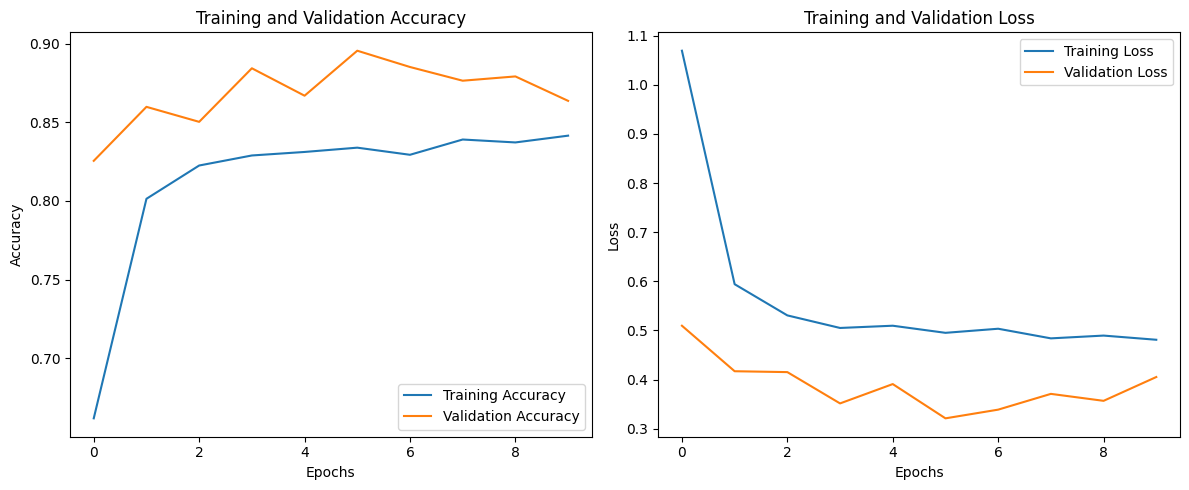

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Get predictions for the test dataset
predictions = model.predict(test_dataset)

# If you need probabilities, use tf.nn.softmax (for logits)
predicted_probabilities = tf.nn.softmax(predictions).numpy()

# Convert probabilities to class labels
predicted_classes = np.argmax(predicted_probabilities, axis=-1)

# Collect true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)


57/57 [==============================] - 4s 66ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

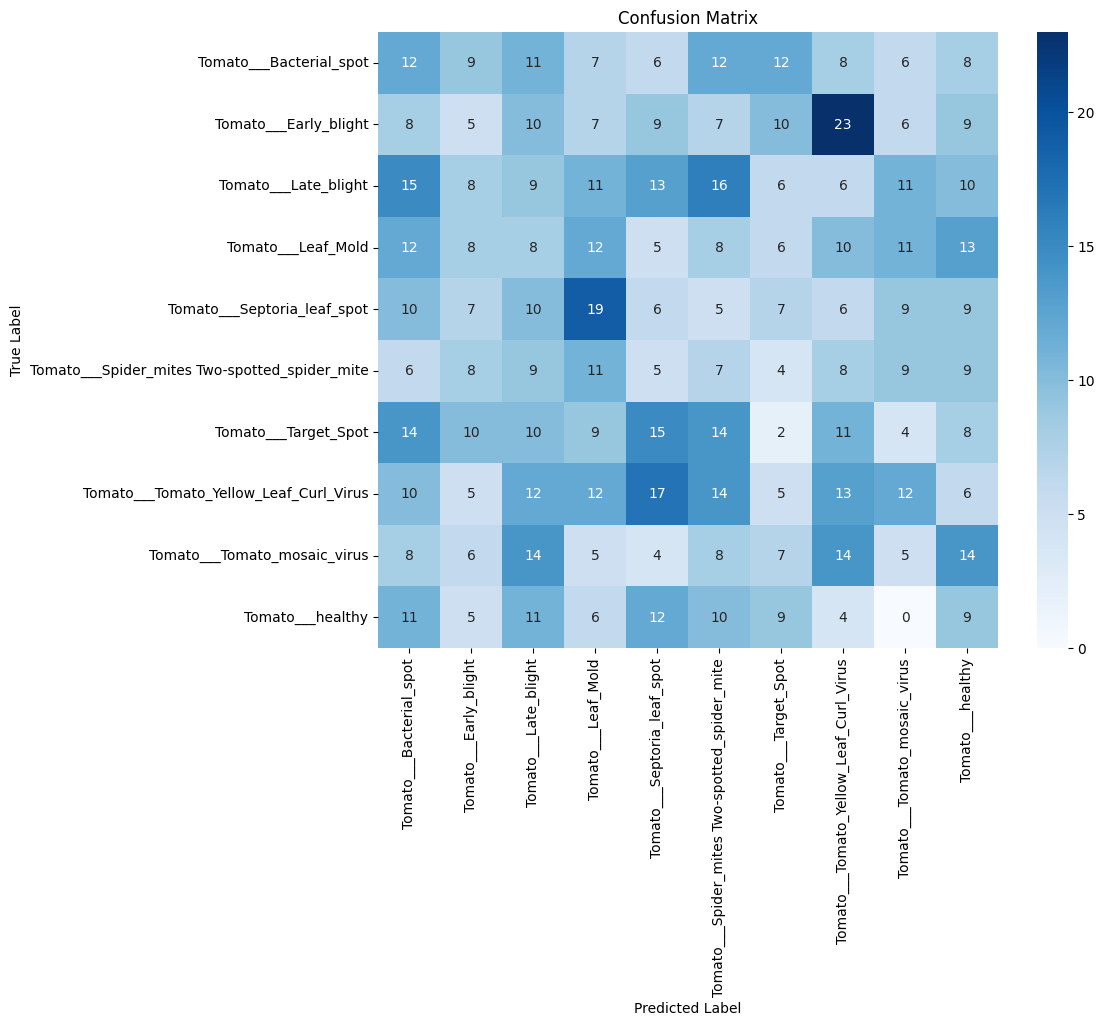

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names
class_names =class_names

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the entire model
model.save('path_to_my_model.h5')  # Save as HDF5 file

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
